In [8]:
from mylib.statistic_test import *
from mazepy.datastruc.neuact import NeuralTrajectory, SpikeTrain
from mazepy.datastruc.variables import VariableBin
from mylib.calcium.dsp_ms import classify_lap

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

code_id = "0858 - Map Decomposition"
loc = os.path.join(figpath, "Dsp", code_id)
mkdir(loc)

def get_lapwise_ratemap(trace: dict):    
    beg_time, end_time = trace['lap beg time'], trace['lap end time']
    beg_idx = np.array([np.where(trace['correct_time'] >= beg_time[i])[0][0] for i in range(beg_time.shape[0])])
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg_idx)
    smoothed_map = np.zeros((trace['n_neuron'], 144, beg_idx.shape[0]), dtype = np.float64)
    time_boundaries = [trace[f'node {i}']['ms_time_behav'][0] for i in range(10)] + [trace['ms_time'][-1]]
    
    for i in tqdm(range(beg_idx.shape[0])):
        
        spike_idx = np.where(
            (trace['ms_time'] >= beg_time[i]) & (trace['ms_time'] <= end_time[i]) &
            (np.isnan(trace['spike_nodes_original']) == False)
        )[0]
        
        spike_nodes = spike_nodes_transform(trace['spike_nodes_original'][spike_idx].astype(np.int64), 12)-1
        Spikes = trace['Spikes_original'][:, spike_idx]
        
        spike_train = SpikeTrain(
            activity=Spikes,
            time=trace['ms_time'][spike_idx],
            variable=VariableBin(spike_nodes),
        )
        
        rate_map = spike_train.calc_tuning_curve(144, t_interv_limits=100)
        smoothed_map[:, :, i] = rate_map.to_array() #@ trace['Ms'].T
    
    nodes = np.digitize((beg_time + end_time) / 2, time_boundaries)-1
    
    return smoothed_map, routes, nodes
    
def get_init_centroid(route: int, trace: dict):
    bins = np.concatenate([
        Father2SonGraph[i] for i in CP_DSP[route]
    ])
    
    lists = [0] if route in [1, 2, 3] else [5]
    cent1 = trace[f'node {[0, 1, 2, 3, 6, 7, 8][route]}']['smooth_map_all'][:, bins-1].T.flatten()
    cent0 = np.vstack([trace[f'node {n}']['smooth_map_all'][:, bins-1].T.flatten() for n in lists])
    cent0 = np.mean(cent0, axis=0)
        
    return cent0, cent1

def _preprocess(route: int, smoothed_map: np.ndarray, routes: np.ndarray, nodes: np.ndarray, _range: np.ndarray):
    idx1 = np.where(routes == route)[0]
    if route in [1, 2, 3]:
        idx0 = np.where(nodes == 0)[0]
    else:
        idx0 = np.where(nodes == 5)[0]
    
    """
    bins = np.concatenate([
        Father2SonGraph[i] for i in CP_DSP[route]
    ])
    """
    bins = CP_DSP[route][_range]
    # smoothed_map = smoothed_map[:, bins-1, :]
    routes = routes[np.concatenate([idx0, idx1])]
    nodes = nodes[np.concatenate([idx0, idx1])]
    
    smoothed_map = np.transpose(smoothed_map, (2, 1, 0))
    X = np.reshape(smoothed_map, (smoothed_map.shape[0], smoothed_map.shape[1]*smoothed_map.shape[2]))
    
    cent0 = np.mean(X[idx0, :], axis=0)
    cent1 = np.mean(X[idx1, :], axis=0)
    
    return X[np.concatenate([idx0, idx1]), :], routes, nodes, cent0, cent1

        E:\Data\FinalResults\Dsp\0858 - Map Decomposition is already existed!


# Cross-day Stability

In [ ]:
if exists(join(figdata, f"{code_id} .pkl")):
    with open(join(figdata, f"{code_id}.pkl"), "rb") as f:
        Data = pickle.load(f)
else:
    Data = {
        "MiceID": [],
        "Session": [],
        "Route": [],
        "Corr": [],
        "Type": []
    }
    for m, mouse in enumerate([10212, 10224, 10227, 10232]):
        with open(f_CellReg_dsp['cellreg_folder'][m+1], 'rb') as handle:
            index_map = pickle.load(handle)
            
            if mouse != 10232:
                index_map = index_map[1:, :]
            
            index_map = index_map.astype(np.int64)
        file_idx = np.where(f2['MiceID'] == mouse)[0]
        
        for j in tqdm(range(6)):
            with open(f2['Trace File'][file_idx[j]], 'rb') as handle:
                trace1 = pickle.load(handle)
            
            with open(f2['Trace File'][file_idx[j+1]], 'rb') as handle:
                trace2 = pickle.load(handle)
        
            cell_idx = np.where((index_map[j, :] != 0)&(index_map[j+1, :] != 0))[0]
            
            
            for r in range(1, 7):
                bins = np.concatenate([Father2SonGraph[i] for i in CP_DSP[r][:5]])
                
                cell_idx_i = np.where(
                    (trace1[f'node {nodes[r-1]}']['is_placecell'][index_map[j, cell_idx]-1] == 1) |
                    (trace2[f'node {nodes[r-1]}']['is_placecell'][index_map[j+1, cell_idx]-1] == 1)
                )[0]
                cell_idx_i = cell_idx[cell_idx_i]
                smoothed_map1 = trace1[f"node {nodes[r-1]}"]['smooth_map_all'][index_map[j, cell_idx_i]-1, :][:, bins-1]
                smoothed_map2 = trace2[f"node {nodes[r-1]}"]['smooth_map_all'][index_map[j+1, cell_idx_i]-1, :][:, bins-1]
            
                Data["MiceID"].append(mouse)
                Data["Session"].append(j)
                Data["Route"].append(r)
                Data["Corr"].append(np.corrcoef(
                    smoothed_map1.flatten(),
                    smoothed_map2.flatten()
                )[0, 1])
                Data["Type"].append("Exp.")
            
                # Route 1
                corr_ctrl = np.zeros(4, dtype=np.float64)
                for n, d in enumerate([0, 4, 5, 9]):
                    cell_idx_i = np.where(
                        (trace1[f'node {nodes[r-1]}']['is_placecell'][index_map[j, cell_idx]-1] == 1) |
                        (trace2[f'node {nodes[r-1]}']['is_placecell'][index_map[j+1, cell_idx]-1] == 1)
                    )[0]
                    cell_idx_i = cell_idx[cell_idx_i]
                    
                    smoothed_map1 = trace1[f"node {d}"]['smooth_map_all'][index_map[j, cell_idx_i]-1, :][:, bins-1]
                    smoothed_map2 = trace2[f"node {d}"]['smooth_map_all'][index_map[j+1, cell_idx_i]-1, :][:, bins-1]
                    
                    corr_ctrl[n] = np.corrcoef(
                        smoothed_map1.flatten(),
                        smoothed_map2.flatten()
                    )[0, 1]
                
                Data["MiceID"].append(mouse)
                Data["Session"].append(j)
                Data["Route"].append(r)
                Data["Corr"].append(np.nanmean(corr_ctrl))
                Data["Type"].append("Ctrl.")
                
    for k in Data.keys():
        Data[k] = np.array(Data[k])
    
    with open(join(figdata, f"{code_id}.pkl"), "wb") as f:
        pickle.dump(Data, f)
        
    D = pd.DataFrame(Data)
    D.to_excel(join(figdata, f"{code_id}.xlsx"), index=False)
    print(Data['Corr'].shape)

  0%|          | 0/6 [00:01<?, ?it/s]


NameError: name 'nodes' is not defined

(0.0, 0.8)

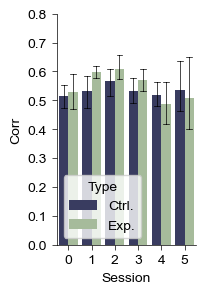

In [5]:
idx = np.where((Data['Route'] == 1))[0]
SubData = SubDict(Data, Data.keys(), idx)

fig = plt.figure(figsize=(1.8, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
"""
sns.stripplot(
    x = 'Session',
    y='Corr',
    data=SubData,
    hue='Type',
    palette = RemappingPalette,
    hue_order = ['Ctrl.', 'Exp.'],
    size = 6,
    linewidth=0.2,
    dodge=True,
    jitter=0.2,
    ax = ax,
    zorder=1
)
"""
sns.barplot(
    x = 'Session',
    y='Corr',
    data=SubData,
    hue='Type',
    palette = RemappingPalette,
    hue_order = ['Ctrl.', 'Exp.'],
    ax = ax,
    zorder=2,
    capsize=0.5,
    linewidth=0.5,
    width=0.8,
    err_kws={"color": 'k', 'linewidth': 0.5}
)

ax.set_ylim(0, 0.8)

In [3]:
with open(f2['Trace File'][34], 'rb') as handle:
    trace = pickle.load(handle)

smoothed_map, routes, nodes = get_lapwise_ratemap(trace)

  0%|          | 0/130 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 130/130 [00:00<00:00, 263.68it/s]


e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

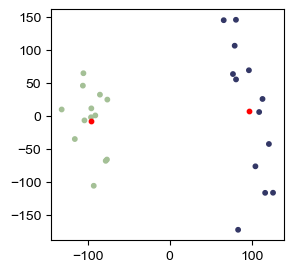

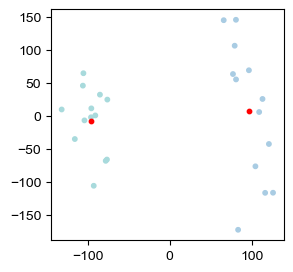

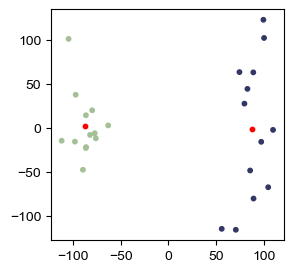

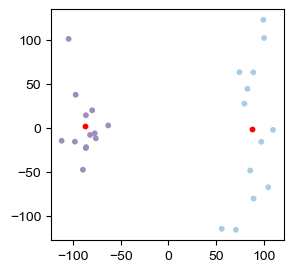

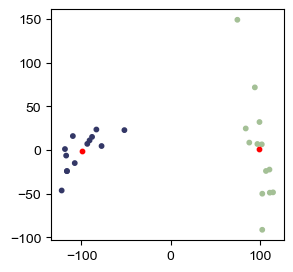

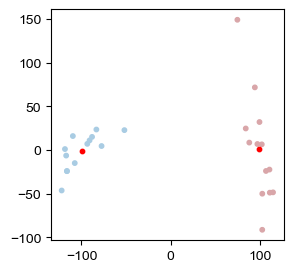

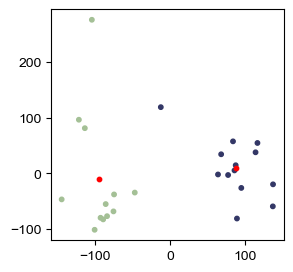

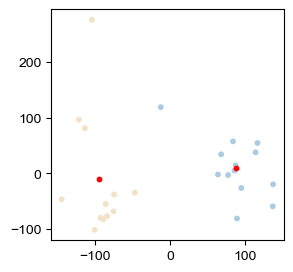

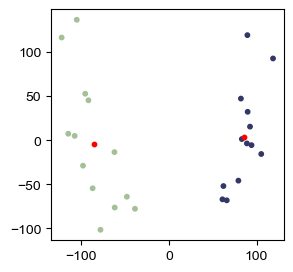

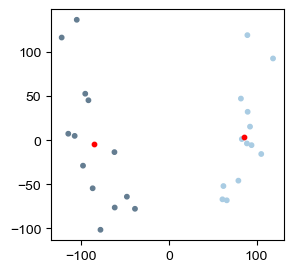

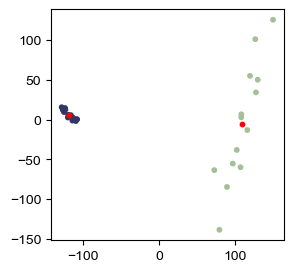

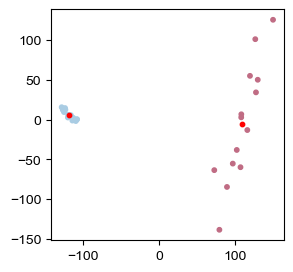

In [ ]:
for i in range(1, 7):
    smoothed_map_p, routes_p, nodes_p, cent0, cent1 = _preprocess(i, smoothed_map, routes, nodes)
    
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(smoothed_map_p)
    kmean = KMeans(n_clusters=2, init=np.vstack([cent0, cent1]))
    kmean.fit(smoothed_map_p)
    labels = kmean.labels_
    
    plt.figure(figsize=(3, 3))
    plt.scatter(
        reduced_data[:, 0], 
        reduced_data[:, 1], 
        s=10,
        c=MAPPaletteRGBA[labels, :] # DSPPaletteRGBA[routes_p, :]#
    )
    centrd = pca.transform(np.vstack([cent0, cent1]))
    plt.scatter(
        centrd[:, 0], 
        centrd[:, 1], 
        s=10,
        c='red'
    )
    plt.figure(figsize=(3, 3))
    plt.scatter(
        reduced_data[:, 0], 
        reduced_data[:, 1], 
        s=10,
        c=DSPPaletteRGBA[routes_p, :] # MAPPaletteRGBA[labels, :]#
    )
    centrd = pca.transform(np.vstack([cent0, cent1]))
    plt.scatter(
        centrd[:, 0], 
        centrd[:, 1], 
        s=10,
        c='red'
    )

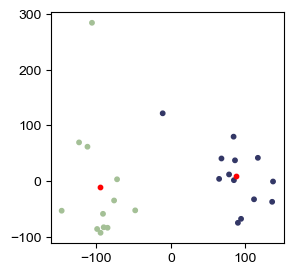

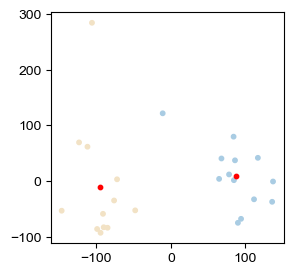